In [1]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import OneHotEncoder
dataset=pandas.read_csv("train.csv")

In [2]:
#data cleaning
def data_cleaning(data:pandas.DataFrame):
    data["VIP"]=data["VIP"].replace(to_replace=numpy.nan,value=data["VIP"].mode()[0])
    data["CryoSleep"]=data["CryoSleep"].replace(to_replace=numpy.nan,value=data["CryoSleep"].mode()[0])
    data["Age"]=data["Age"].replace(to_replace=numpy.nan,value=data["Age"].mean())
    data["RoomService"]=data["RoomService"].replace(to_replace=numpy.nan,value=data["RoomService"].mean())
    data["FoodCourt"]=data["FoodCourt"].replace(to_replace=numpy.nan,value=data["FoodCourt"].mean())
    data["ShoppingMall"]=data["ShoppingMall"].replace(to_replace=numpy.nan,value=data["ShoppingMall"].mean())
    data["Spa"]=data["Spa"].replace(to_replace=numpy.nan,value=data["Spa"].mean())
    data["VRDeck"]=data["VRDeck"].replace(to_replace=numpy.nan,value=data["VRDeck"].mean())
def data_preparation(data):
    data["Spending"]=data["RoomService"]+data["FoodCourt"]+data["ShoppingMall"]+data["Spa"]+data["VRDeck"]
    for x in range(len(data)):
        a=str(data.loc[x,"Cabin"])
        data.loc[x,"Deck"]=ord(a[0])
    for x in range(len(data)):
        data.loc[x,"Group"]=data.loc[x,"PassengerId"][:4]
    group={}
    for x in range(len(data)):
        g=data.loc[x,"Group"]
        if group.get(g,0)==0:
            group[g]=0
        group[g]+=1
    for x in range(len(data)):
        data.loc[x,"GroupSize"]=group.get(data.loc[x,"Group"])
    data["Cabin"]=data["Cabin"].replace(to_replace=numpy.nan,value="Unknown")
def get_train_data(data):
    data_cleaning(data)
    data_preparation(data)
    data.drop(["Spending"],axis=1,inplace=True)
    transported=data["Transported"]
    data.drop(["Transported","Name","Cabin","Group","PassengerId"],axis=1,inplace=True)
    data=pandas.get_dummies(data,columns=["HomePlanet","Destination"])
    return data,transported
def generate_output(model):
    test_set=pandas.read_csv("test.csv")
    data_cleaning(test_set)
    data_preparation(test_set)
    test_set.drop(["Name","Cabin","Group","PassengerId","Spending"],axis=1,inplace=True)
    test_set=pandas.get_dummies(test_set,columns=["HomePlanet","Destination"])
    result=pandas.DataFrame({"PassengerId":pandas.read_csv("test.csv")["PassengerId"],"Transported":model.predict(test_set)})
    result.set_index("PassengerId",inplace=True)    
    result.to_csv("titanic_2_output.csv")  
def plot_metrics(y_true, X, model):
    cm = confusion_matrix(y_true, model.predict(X))
    ax = plt.subplot()
    seaborn.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(['False', 'True']) 
    ax.yaxis.set_ticklabels(['False', 'True']) 
    plt.show() 
    print("Confusion Matrix:\n", cm)
    print("Accuracy:", model.score(X=X, y=y_true))

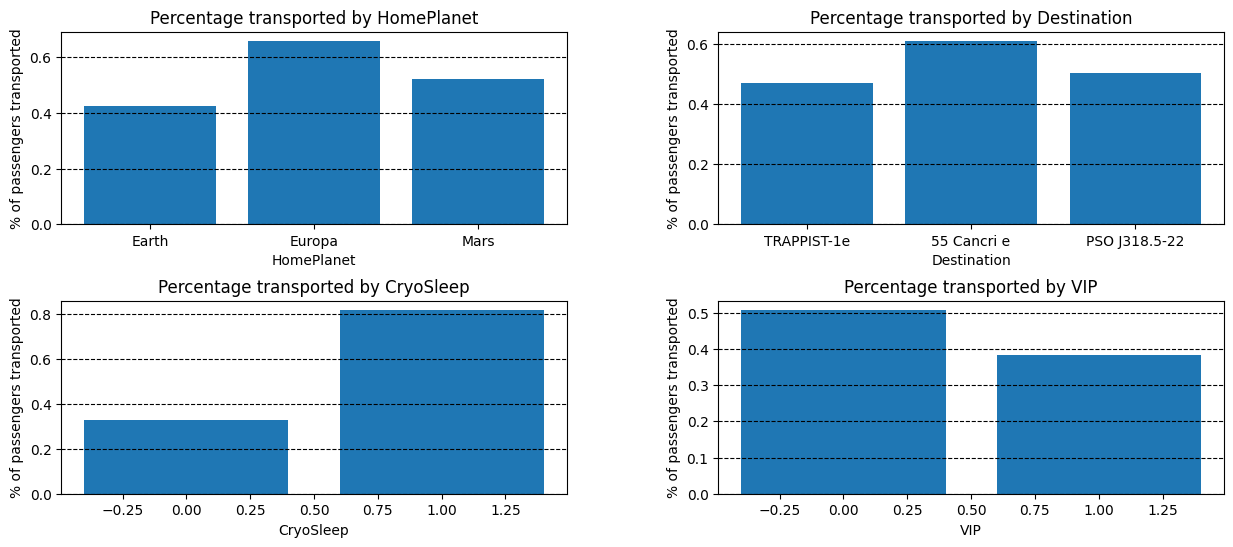

Correclation
                   Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           1.000000     0.068723   0.130421      0.033133  0.123970   
RoomService   0.068723     1.000000  -0.015889      0.054480  0.010080   
FoodCourt     0.130421    -0.015889   1.000000     -0.014228  0.221891   
ShoppingMall  0.033133     0.054480  -0.014228      1.000000  0.013879   
Spa           0.123970     0.010080   0.221891      0.013879  1.000000   
VRDeck        0.101007    -0.019581   0.227995     -0.007322  0.153821   
Transported  -0.075026    -0.244611   0.046566      0.010141 -0.221131   

                VRDeck  Transported  
Age           0.101007    -0.075026  
RoomService  -0.019581    -0.244611  
FoodCourt     0.227995     0.046566  
ShoppingMall -0.007322     0.010141  
Spa           0.153821    -0.221131  
VRDeck        1.000000    -0.207075  
Transported  -0.207075     1.000000  


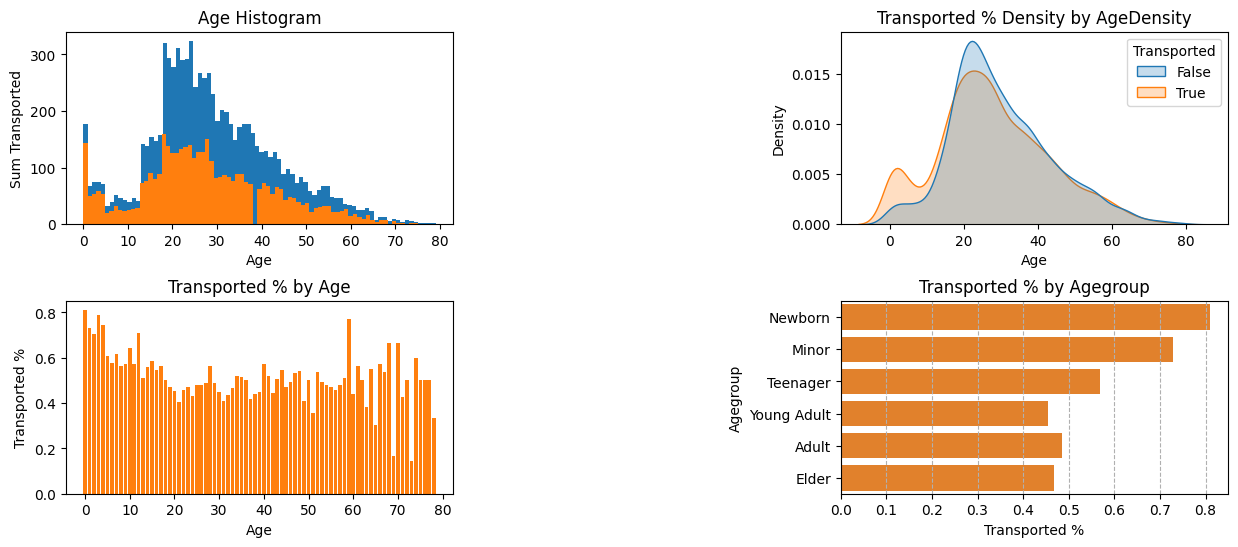

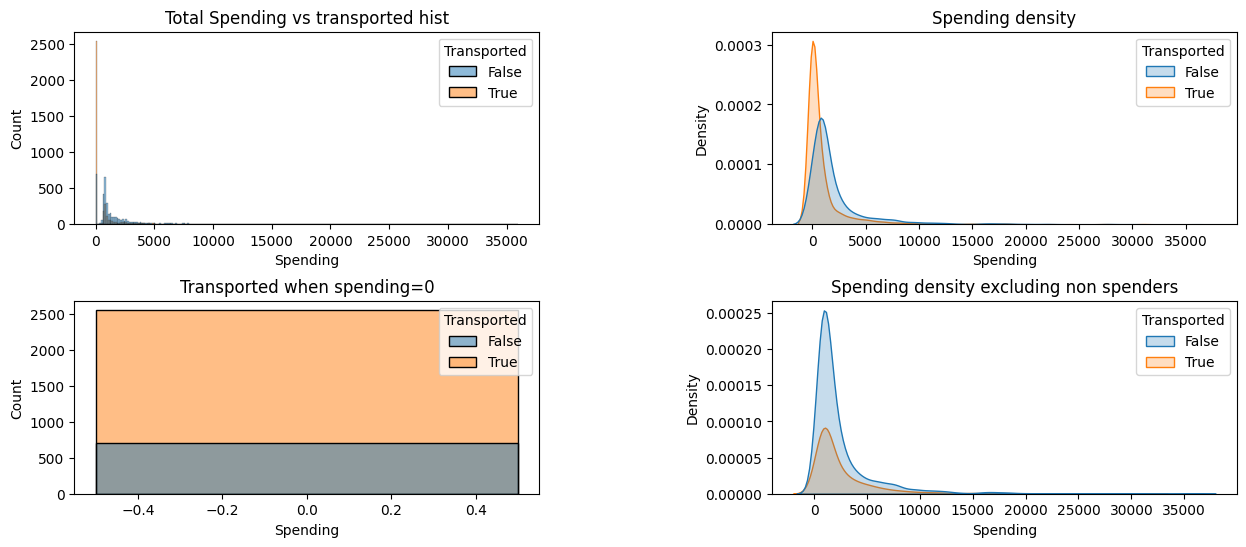

<Axes: title={'center': 'Transported density travelling with entourage'}, xlabel='Entourage', ylabel='Density'>

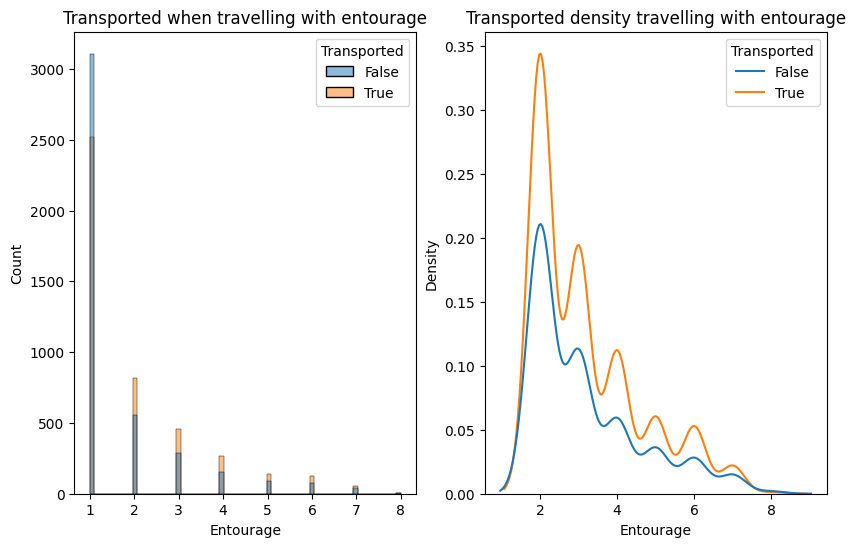

In [3]:
#data analysis
analysis_data=dataset.copy()
data_preparation(analysis_data)
transported=analysis_data["Transported"]==True
transported=analysis_data[transported]
def plot_transported_percentage(col:str,index:int,data):
    plt.subplot(index)
    plt.grid(visible=True,axis="y",which="major",color="k",linestyle="--")
    plt.ylabel("% of passengers transported")
    plt.xlabel(col)
    data=transported[col].value_counts()/analysis_data[col].value_counts()
    data=data.reset_index()
    plt.bar(data[col],height=data["count"])
    plt.title(label="Percentage transported by " + col)
plt.figure(figsize=(15,6))
plot_transported_percentage("HomePlanet",221,analysis_data)
plot_transported_percentage("Destination",222,analysis_data)
plot_transported_percentage("CryoSleep",223,analysis_data)
plot_transported_percentage("VIP",224,analysis_data)
plt.subplots_adjust(hspace=0.4,wspace=0.3)
plt.show()
print("Correclation")
print(analysis_data[["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck","Transported"]].corr())

plt.figure(figsize=(15,6))
plt.subplot(221)
t=analysis_data["Transported"]==1
t1=analysis_data[t]
plt.hist(x=analysis_data["Age"],bins=80)
plt.hist(x=t1["Age"],bins=80)
plt.ylabel("Sum Transported")
plt.xlabel("Age")
plt.title("Age Histogram")
age_map={}
age_map_transported={}
for x in range(len(analysis_data)):
    age=analysis_data.loc[x,"Age"]
    if age_map.get(age,-1)==-1:
        age_map[age]=0
        age_map_transported[age]=0
    age_map[age]+=1
    if analysis_data.loc[x,"Transported"]==1:
        age_map_transported[age]+=1       
age_map_transported_percentage={}
for x in age_map:
    if age_map_transported[x]>0:
        age_map_transported_percentage[x]=age_map_transported[x]/age_map[x]
a=pandas.DataFrame(age_map_transported_percentage,index=["Age"])
a=a.transpose()
a.reset_index(inplace=True)
plt.subplot(223)
plt.bar(x=a["index"],height=a["Age"],color='tab:orange')
plt.xlabel("Age")
plt.ylabel("Transported %")
plt.title("Transported % by Age")
plt.subplots_adjust(hspace=0.4,wspace=1)

plt.subplot(222)
plt.title("Transported % Density by AgeDensity")
seaborn.kdeplot(data=analysis_data, x="Age", hue="Transported", fill=True)

def get_percentage_by_age_group(start:int,end:int):
    tranported=0
    total=0
    for x in range(start,end):
        total+=age_map.get(x,0)
        tranported+=age_map_transported.get(x,0)
    return tranported/total
newborn=get_percentage_by_age_group(0,1)
minor=get_percentage_by_age_group(1,6)
teenager=get_percentage_by_age_group(6,18)
young_adult=get_percentage_by_age_group(18,25)
adult=get_percentage_by_age_group(25,60)
elder=get_percentage_by_age_group(60,81)
age_groups=[newborn,minor,teenager,young_adult,adult,elder]
age_groups_df=pandas.DataFrame(data=age_groups,columns=["Age"],index=["Newborn","Minor","Teenager","Young Adult","Adult","Elder"])
age_groups_df.reset_index(inplace=True)
plt.subplot(224)
plt.title("Transported % by Agegroup")
plt.xlabel("Transported %")
plt.ylabel("Agegroup")
plt.grid(visible=True,linestyle="--")
seaborn.barplot(data=age_groups_df,x="Age",y="index",color="tab:orange")
plt.show()

#Spending
plt.figure(figsize=(15,6))
plt.subplots_adjust(hspace=0.4,wspace=0.5)
plt.subplot(221)
plt.title("Total Spending vs transported hist")
seaborn.histplot(data=analysis_data, x="Spending", hue="Transported")
plt.subplot(222)
plt.title("Spending density")
seaborn.kdeplot(data=analysis_data, x="Spending", hue="Transported", fill=True)
plt.subplot(224)
plt.title("Spending density excluding non spenders")
spending_true=analysis_data["Spending"]>0
spending_true2=analysis_data[spending_true]
seaborn.kdeplot(data=spending_true2, x="Spending", hue="Transported", fill=True)
plt.subplot(223)
plt.title("Transported when spending=0")
spending_false=analysis_data["Spending"]==0
spending_false2=analysis_data[spending_false]
seaborn.histplot(data=spending_false2, x="Spending", hue="Transported", fill=True)
plt.show()

#Cabin occupation
cabin_occupation={}
for x in range(len(analysis_data)):
    cabin =analysis_data.loc[x,"Cabin"]
    if cabin_occupation.get(cabin,0)==0:
        cabin_occupation[cabin]=0
    cabin_occupation[cabin]+=1
for x in range(len(analysis_data)):
    if analysis_data.loc[x,"Cabin"]=="Unknown":
        analysis_data.loc[x,"Entourage"]=1
    else:
        analysis_data.loc[x,"Entourage"]=cabin_occupation.get(analysis_data.loc[x,"Cabin"])
plt.figure(figsize=(15,6))
et_greater1=analysis_data["Entourage"]>1
et_greater1_2=analysis_data[et_greater1]
plt.subplot(131)
plt.title("Transported when travelling with entourage")
seaborn.histplot(data=analysis_data,x="Entourage",hue="Transported")
et_eq1=analysis_data["Entourage"]==1
et_eq1_2=analysis_data[et_eq1]
#plt.subplot(132)
#seaborn.histplot(data=et_eq1_2,x="Entourage",hue="Transported")
plt.subplot(132)
plt.title("Transported density travelling with entourage")
seaborn.kdeplot(data=et_greater1_2,x="Entourage",hue="Transported")


In [4]:
train_data,transported=get_train_data(dataset.copy())

C:\Users\Kay\AppData\Local\Temp\ipykernel_28256\4070541989.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["VIP"]=data["VIP"].replace(to_replace=numpy.nan,value=data["VIP"].mode()[0])
C:\Users\Kay\AppData\Local\Temp\ipykernel_28256\4070541989.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["CryoSleep"]=data["CryoSleep"].replace(to_replace=numpy.nan,value=data["CryoSleep"].mode()[0])


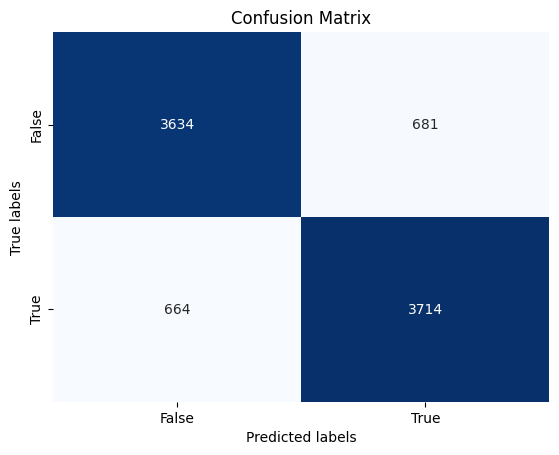

Confusion Matrix:
 [[3634  681]
 [ 664 3714]]
Accuracy: 0.8452778097319682
CPU times: total: 15.4 s
Wall time: 57min 17s


In [5]:
%%time
X_train=train_data
Y_train=transported
cv_params = {'max_depth': [2,3,4,5,6,None],'max_features': [1.0],'max_samples': [1.0],
             'min_samples_leaf': [5,6,7,8,9,10],'min_samples_split': [2,2,4],'n_estimators': [200,225,250,275,300,350],'criterion': ["gini", "entropy", "log_loss"]}

forest = RandomForestClassifier(random_state=10)
forest_cv=GridSearchCV(forest,cv_params,scoring="accuracy",cv=4,refit="accuracy",n_jobs=4)
forest_cv.fit(X_train,Y_train)
plot_metrics(Y_train,X_train,forest_cv)

C:\Users\Kay\PycharmProjects\practice\venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


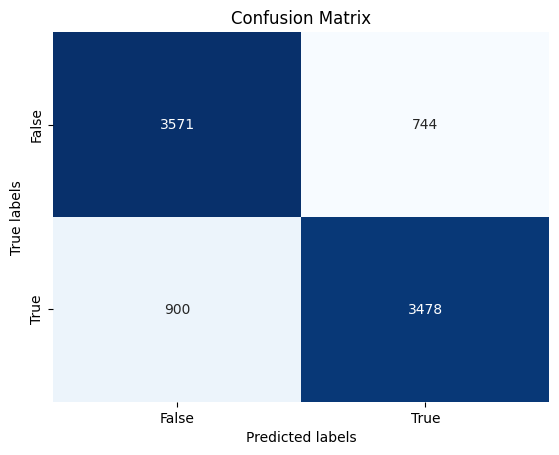

Confusion Matrix:
 [[3571  744]
 [ 900 3478]]
Accuracy: 0.8108823191073278
CPU times: total: 1h 11min 37s
Wall time: 34min 12s


In [6]:
%%time
knn= KNN()
cv_params = {'n_neighbors': [2,3,4,5,6,7,8,9,10],'leaf_size': [10,15,20,25,30,35,40,45],'weights': ["uniform","distance"],
             'algorithm': ["auto","kd_tree","ball_tree"],'p':[1,2,3]}
knn_cv=GridSearchCV(knn,cv_params,scoring="accuracy",cv=4,refit="accuracy")
knn_cv.fit(X_train,Y_train)
plot_metrics(Y_train,X_train,knn_cv)

In [7]:
generate_output(forest_cv)

C:\Users\Kay\AppData\Local\Temp\ipykernel_28256\4070541989.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["VIP"]=data["VIP"].replace(to_replace=numpy.nan,value=data["VIP"].mode()[0])
C:\Users\Kay\AppData\Local\Temp\ipykernel_28256\4070541989.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["CryoSleep"]=data["CryoSleep"].replace(to_replace=numpy.nan,value=data["CryoSleep"].mode()[0])
